In [5]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from flask import Flask, request, jsonify

In [7]:
# Load dataset
df = pd.read_csv("../Data/Fraud Original Full.csv")

# Exploratory Data Analysis (EDA)
print("Class Distribution:")
print(df["fraud"].value_counts(normalize=True))  # Should show ~4.7% fraud

# Define features (X) and target variable (y)
X = df.drop(columns=["fraud"])  # Remove target variable
y = df["fraud"]

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split (Stratified to maintain fraud ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)


Class Distribution:
fraud
0    0.952367
1    0.047633
Name: proportion, dtype: float64


In [8]:
# Handle Imbalance - SMOTE Oversampling
smote = SMOTE(sampling_strategy=0.2, random_state=42)  # Increase fraud cases to 20%
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Undersampling Majority Class
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # 50-50 ratio
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)


C:\Users\ryan\anaconda3\envs\fraud_env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\ryan\anaconda3\envs\fraud_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ryan\anaconda3\envs\fraud_env\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\ryan\anaconda3\envs\fraud_env\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_f

In [9]:
# Neural Network Model
model = Sequential([
    Input(shape=(X_train_res.shape[1],)),
    Dense(32, activation='relu'),
    Dropout(0.2),  # Reduces overfitting
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_res, y_train_res, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Random Forest Model
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train_res, y_train_res)

# XGBoost Model
xgb = XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train_res, y_train_res)

Epoch 1/20
12453/12453 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9332 - loss: 0.1498 - val_accuracy: 0.9835 - val_loss: 0.0363
Epoch 2/20
12453/12453 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9801 - loss: 0.0489 - val_accuracy: 0.9852 - val_loss: 0.0328
Epoch 3/20
12453/12453 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9822 - loss: 0.0438 - val_accuracy: 0.9873 - val_loss: 0.0281
Epoch 4/20
12453/12453 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9827 - loss: 0.0417 - val_accuracy: 0.9888 - val_loss: 0.0260
Epoch 5/20
12453/12453 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9836 - loss: 0.0410 - val_accuracy: 0.9892 - val_loss: 0.0245
Epoch 6/20
12453/12453 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9840 - loss: 0.0398 - val_accuracy: 0.9865 - val_loss: 0.0302
Epoch 7/20
12453/12453 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9843 - loss: 0.0389 - val_accuracy: 0.9894 - val_loss: 0.0234
Epoch 8/20
12453/12453 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 

C:\Users\ryan\anaconda3\envs\fraud_env\lib\site-packages\xgboost\core.py:158: UserWarning: [15:06:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [10]:
# Evaluate on Full Dataset
y_pred_probs = model.predict(X_test)  # NN Predictions
y_pred = (y_pred_probs > 0.5).astype(int)

print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_probs))

4670/4670 ━━━━━━━━━━━━━━━━━━━━ 3s 593us/step
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    142319
           1       0.90      0.93      0.92      7118

    accuracy                           0.99    149437
   macro avg       0.95      0.96      0.96    149437
weighted avg       0.99      0.99      0.99    149437

ROC-AUC Score: 0.9988172877688245


ExactExplainer explainer: 149438it [55:51, 44.48it/s]                              


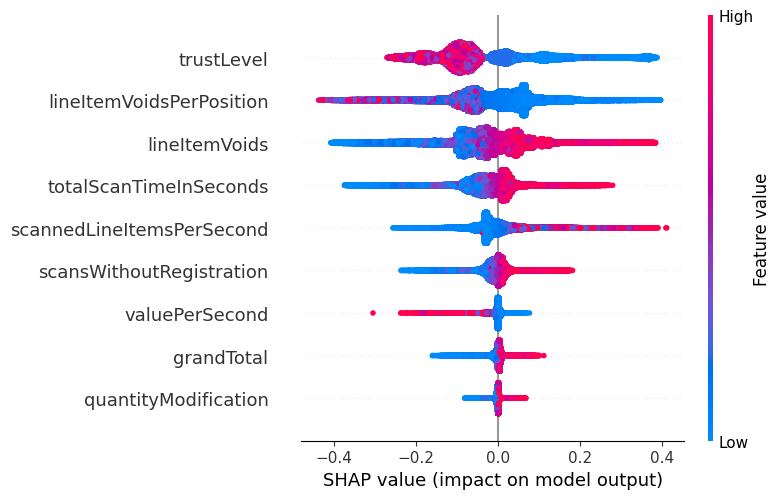

In [11]:
# SHAP Explanation
explainer = shap.Explainer(model, X_train_res)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [14]:


# Save Model
model.save("../Models/fraud_model.h5")

# Deploy as API
app = Flask(__name__)
loaded_model = tf.keras.models.load_model("../Models/fraud_model.h5")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    df = pd.DataFrame(data)
    df_scaled = scaler.transform(df)  # Apply same preprocessing
    prediction = (loaded_model.predict(df_scaled) > 0.5).astype(int)
    return jsonify({"fraud_prediction": prediction.tolist()})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


SystemExit: 1

C:\Users\ryan\anaconda3\envs\fraud_env\lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
